In [2]:
# 数据分析
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 通用
import random
import time
from datetime import datetime
import copy
import argparse
from tqdm import tqdm
import os
from pathlib import Path

# Pytorch
import torch
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils import data
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


# 读取数据集
from utils.helper_CWRU import get_df_all, download

#网络
from utils.train_utils import accuracy, average_weights
from utils.init_utils import seed_torch
from utils.maml_model import Net4CNN, Net4CNN_add, Net4CNN_PU, BP
import learn2learn as l2l
import optuna
import plotly

In [3]:
argparser = argparse.ArgumentParser()

#数据
argparser.add_argument('--signal_length', type=int, help='signal_length', default=1024)
argparser.add_argument('--ways', type=int, help='n way', default=10)
#argparser.add_argument('--shots', type=int, help=' ', default=5)
#argparser.add_argument('--train_task_num', type=int, help=' ', default=10000)
#argparser.add_argument('--valid_task_num', type=int, help=' ', default=10000)
#argparser.add_argument('--test_task_num',  type=int, help=' ', default=10000)
#argparser.add_argument('--sample_time',  type=int, help=' ', default=100)

#其他
argparser.add_argument('--device', type=int, help='n way', default=torch.device('cuda'))  #torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

#超参数
argparser.add_argument('--meta_lr', type=float, help=' ', default=0.01)
argparser.add_argument('--fast_lr', type=float, help=' ', default=0.01)
argparser.add_argument('--local_lr', type=float, help=' ', default=0.001)
argparser.add_argument('--epoch', type=int, help=' ', default=1000)
argparser.add_argument('--train_meta_batch_size', type=int, help=' ', default=3)
argparser.add_argument('--valid_meta_batch_size', type=int, help=' ', default=3)
argparser.add_argument('--test_meta_batch_size' , type=int, help=' ', default=1)
argparser.add_argument('--local_epoch' , type=int, help=' ', default=1)
#argparser.add_argument('--local_batch_size' , type=int, help=' ', default=512)

args = argparser.parse_args(args = [])

In [4]:
#这个运行一次

def condition_map(filename):
    if '_0.mat' in filename:return 0
    elif '_1.mat' in filename:return 1
    elif '_2.mat' in filename:return 2
    elif '_3.mat' in filename:return 3
    else:pass

working_dir = Path('.')
DE12_path = Path("./Data/CWRU/raw/12k_DE")
NO_path   = Path("./Data/CWRU/raw/Normal")

class_num = 10
n_each_class = 100
signal_length = 1024

df_NO   = get_df_all(NO_path  , segment_length= signal_length, normalize=True)
df_DE12 = get_df_all(DE12_path, segment_length= signal_length, normalize=True)    

df_eachclass_dict = {k:df_DE12[df_DE12['label']==k] for k in range(1,10)}                 #每类样本的字典
df_eachclass_dict[0] = df_NO[df_NO['label']==0]

for v in df_eachclass_dict:                                                               #加入工况信息
    df_eachclass_dict[v]['condition'] = df_eachclass_dict[v]['filename'].apply(condition_map)

def gene_data(df_eachclass_dict, condition, class_num, n_each_class):                     #为某种工况产生数据
    #该工况下的每类样本
    df_eachclass_on_condition_dict = {}
    for k, v in  df_eachclass_dict.items():
        df_eachclass_on_condition_dict[k] = v[v['condition'] == condition]
        df_eachclass_on_condition_dict[k].index = range(len(df_eachclass_on_condition_dict[k]))
        #print(len(df_eachclass_on_condition_dict[k]))    
    x = np.zeros((class_num,n_each_class, signal_length));y = np.zeros((class_num,n_each_class))
    for class_ in range(class_num):
        x[class_] = np.array(df_eachclass_on_condition_dict[class_].iloc[0:n_each_class,2:-1])
        y[class_] = np.array(df_eachclass_on_condition_dict[class_].iloc[0:n_each_class,0])
    return x, y
    
x_c0, y_c0 = gene_data(df_eachclass_dict, 0, class_num, n_each_class);print(x_c0.shape, y_c0.shape);np.save('./Data/CWRU/generated/x_c0.npy', x_c0);np.save('./Data/CWRU/generated/y_c0.npy', y_c0)
x_c1, y_c1 = gene_data(df_eachclass_dict, 1, class_num, n_each_class);print(x_c1.shape, y_c1.shape);np.save('./Data/CWRU/generated/x_c1.npy', x_c1);np.save('./Data/CWRU/generated/y_c1.npy', y_c1)
x_c2, y_c2 = gene_data(df_eachclass_dict, 2, class_num, n_each_class);print(x_c2.shape, y_c2.shape);np.save('./Data/CWRU/generated/x_c2.npy', x_c2);np.save('./Data/CWRU/generated/y_c2.npy', y_c2)
x_c3, y_c3 = gene_data(df_eachclass_dict, 3, class_num, n_each_class);print(x_c3.shape, y_c3.shape);np.save('./Data/CWRU/generated/x_c3.npy', x_c3);np.save('./Data/CWRU/generated/y_c3.npy', y_c3)




/home/hadoop/app/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
class Dataset_CWRU(data.Dataset):
    def __init__(self, args, condition, mode):
        super().__init__()
        self.sample_len = 1024
        #self.task_mode = True if ways == 10 else False
        self.__getdata__(mode, condition)

    def __getdata__(self, mode, condition):
        
        # 工况 K0 下的 10 分类   [类别，每一类取多少个，样本数]
        
        x = np.load('./Data/CWRU/generated/x_c'+str(condition)+'.npy')
        y = np.load('./Data/CWRU/generated/y_c'+str(condition)+'.npy')
        np.random.seed(1)
        np.random.shuffle(x)
        np.random.shuffle(y)

        
        if mode == 'train':
            x = x[:,0:int(0.8*x.shape[1]),:]
            y = y[:,0:int(0.8*y.shape[1])]
        elif mode == 'valid':
            x = x[:,int(0.8*x.shape[1]):,:]
            y = y[:,int(0.8*y.shape[1]):]
        elif mode == 'test':
            pass
            
        self.x = np.array(x, dtype=float)
        self.y = np.array(y, dtype=float)
        self.x = self.x.reshape([-1, 1, self.sample_len])  # x: (n_way*n, len, 1), y: (n_way*n)
        self.y = self.y.reshape(-1)

        
    def __getitem__(self, item):
        x = self.x[item]  # (NC, l)
        y = self.y[item]
        return x, y  # , label

    def __len__(self):
        return len(self.x)  
    


In [7]:

def objective(trial):
    
    batch_size=trial.suggest_int("batch_size", 64, 256,step=64) 
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "Adadelta","Adagrad"])               ##
    lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True)                                                   ##
    
    class FedAvg_learner(object):
        def __init__(self, args):
            self.args = args;h_size = 64;layers = 4;sample_len = 1024;feat_size = (sample_len//2**layers)*h_size
            self.model = Net4CNN_PU(output_size=self.args.ways, hidden_size=h_size, layers=layers, channels=1, embedding_size=feat_size).to(self.args.device).double()
            #self.model = BP().to(self.args.device).double()

        def train(self, model, train_loader):
            opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)                                       ##
            critiren = torch.nn.CrossEntropyLoss(reduction='mean') 
            for local_epoch in range(self.args.local_epoch):
                correct, total = 0, 0
                for x, y in train_loader:
                    x = x.to(args.device); y = y.to(args.device)
                    out = model(x)                      
                    loss = critiren(out, y.long())         
                    opt.zero_grad()           
                    loss.backward()
                    opt.step()
                    correct += torch.eq(torch.argmax(out, dim=1), y).sum()                
                    total += y.shape[0]
            return model, (correct/total).item()

        def valid(self, model, valid_loader):
            with torch.no_grad():
                correct, total = 0, 0
                for x, y in valid_loader:
                    x = x.to(args.device); y = y.to(args.device)
                    out = model(x)                           
                    correct += torch.eq(torch.argmax(out, dim=1), y).sum()                
                    total += y.shape[0]
            return (correct/total).item()

        def test(self, model, test_loader):
            with torch.no_grad():
                correct, total = 0, 0
                for x, y in test_loader:
                    x = x.to(args.device); y = y.to(args.device)
                    out = model(x)                           
                    correct += torch.eq(torch.argmax(out, dim=1), y).sum()                
                    total += y.shape[0]
            return (correct/total).item()


    #### start ####

    path = os.path.join(os.getcwd(), 'Saved_models_CWRU_11.09','FedAvg',datetime.strftime(datetime.now(), '%m%d-%H%M%S'));
    save_path = path
    Net = FedAvg_learner(args)         
       
            
    #数据
    train_loaders = {};valid_loaders = {};test_loaders = {}
    for client in range(Net.args.train_meta_batch_size):
        train_loaders[client] = torch.utils.data.DataLoader(Dataset_CWRU(Net.args, condition=client, mode='train'),batch_size = batch_size,shuffle = True)
        valid_loaders[client] = torch.utils.data.DataLoader(Dataset_CWRU(Net.args, condition=client, mode='valid'),batch_size = batch_size,shuffle = True)
    for client in range(Net.args.test_meta_batch_size):
        test_loaders[client] = torch.utils.data.DataLoader(Dataset_CWRU(Net.args, condition=3, mode='test'),batch_size = batch_size,shuffle = True)
    #模型
    model = Net.model
    w_init = copy.deepcopy(model.state_dict())

    train_accuracy = [];valid_accuracy = [];test_accuracy  = []        #保存每个epoch的准确率
    best_test = 0                                                      #用于保存最佳模型

    for epoch in range(Net.args.epoch):
        t0 = time.time()
        train_acc_in_all_client = 0;  valid_acc_in_all_client = 0;  test_acc_in_all_client = 0

        w_locals = []
        for client in range(Net.args.train_meta_batch_size):
            if epoch == 0:    model.load_state_dict(w_init)
            else:             model.load_state_dict(w_glob)
            model.train()
            model, train_acc = Net.train(model, train_loaders[client])
            train_acc_in_all_client += train_acc
            w_locals.append(copy.deepcopy(model.state_dict()))
        w_glob = average_weights(w_locals)

        for client in range(Net.args.valid_meta_batch_size):
            model.load_state_dict(w_glob)
            model.eval()
            valid_acc = Net.valid(model, valid_loaders[client])
            valid_acc_in_all_client += valid_acc         

        for client in range(Net.args.test_meta_batch_size):
            model.load_state_dict(w_glob)
            model.eval()
            test_acc = Net.test(model, test_loaders[client])
            test_acc_in_all_client += test_acc

        if test_acc_in_all_client / Net.args.test_meta_batch_size > best_test:
            best_test = test_acc_in_all_client / Net.args.test_meta_batch_size
            torch.save(model.state_dict(), save_path)

        train_accuracy.append(train_acc_in_all_client / Net.args.train_meta_batch_size)
        valid_accuracy.append(valid_acc_in_all_client / Net.args.valid_meta_batch_size)
        test_accuracy.append(test_acc_in_all_client / Net.args.test_meta_batch_size)


        ACCURACY = test_acc_in_all_client / Net.args.test_meta_batch_size
        trial.report(ACCURACY, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned() 
        #打印参数
        t1 = time.time()
        if epoch % 20 == 0:                                                                                  
            print(f'Time /epoch: {t1-t0:.4f} s',end='       ');print('Epoch', epoch+1, end='       ')                                                       
            print(f'Train Accuracy:', round(train_acc_in_all_client / Net.args.train_meta_batch_size, 4), end='   ')
            print(f'Valid Accuracy:', round(valid_acc_in_all_client / Net.args.valid_meta_batch_size, 4), end='   ')
            print(f'Test  Accuracy:', round(test_acc_in_all_client  / Net.args.test_meta_batch_size,  4))
    print('best test acc:', best_test)      
    df = pd.DataFrame({'epoch':range(len(train_accuracy)),'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy}, index=range(len(train_accuracy)))
    df.to_csv(save_path + '_result.csv')

    return ACCURACY

In [8]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
print(df)

[I 2022-11-09 09:42:15,894] A new study created in memory with name: no-name-06392c0d-1de5-46fe-9310-233663e74925


Time /epoch: 0.3393 s       Epoch 1       Train Accuracy: 0.1567   Valid Accuracy: 0.1033   Test  Accuracy: 0.099
Time /epoch: 0.3054 s       Epoch 21       Train Accuracy: 0.9233   Valid Accuracy: 0.6   Test  Accuracy: 0.404
Time /epoch: 0.3076 s       Epoch 41       Train Accuracy: 0.9625   Valid Accuracy: 0.8667   Test  Accuracy: 0.73
Time /epoch: 0.3078 s       Epoch 61       Train Accuracy: 0.9775   Valid Accuracy: 0.6433   Test  Accuracy: 0.414
Time /epoch: 0.3295 s       Epoch 81       Train Accuracy: 0.9967   Valid Accuracy: 0.9917   Test  Accuracy: 0.812
Time /epoch: 0.3176 s       Epoch 101       Train Accuracy: 1.0   Valid Accuracy: 0.9983   Test  Accuracy: 0.877
Time /epoch: 0.3158 s       Epoch 121       Train Accuracy: 0.9971   Valid Accuracy: 0.99   Test  Accuracy: 0.932
Time /epoch: 0.3072 s       Epoch 141       Train Accuracy: 1.0   Valid Accuracy: 0.9917   Test  Accuracy: 0.957
Time /epoch: 0.3073 s       Epoch 161       Train Accuracy: 1.0   Valid Accuracy: 0.995   

[I 2022-11-09 09:50:25,947] Trial 0 finished with value: 0.9380000233650208 and parameters: {'batch_size': 256, 'optimizer': 'Adam', 'lr': 0.003403475487080691}. Best is trial 0 with value: 0.9380000233650208.


best test acc: 0.9930000305175781
Time /epoch: 0.6818 s       Epoch 1       Train Accuracy: 0.1733   Valid Accuracy: 0.0983   Test  Accuracy: 0.104
Time /epoch: 0.6489 s       Epoch 21       Train Accuracy: 0.9979   Valid Accuracy: 0.95   Test  Accuracy: 0.786
Time /epoch: 0.6958 s       Epoch 41       Train Accuracy: 1.0   Valid Accuracy: 0.9883   Test  Accuracy: 0.783
Time /epoch: 0.6544 s       Epoch 61       Train Accuracy: 1.0   Valid Accuracy: 0.9867   Test  Accuracy: 0.831
Time /epoch: 0.6474 s       Epoch 81       Train Accuracy: 1.0   Valid Accuracy: 0.9917   Test  Accuracy: 0.803
Time /epoch: 0.6853 s       Epoch 101       Train Accuracy: 0.9992   Valid Accuracy: 0.9917   Test  Accuracy: 0.813
Time /epoch: 0.6569 s       Epoch 121       Train Accuracy: 1.0   Valid Accuracy: 0.995   Test  Accuracy: 0.813
Time /epoch: 0.6546 s       Epoch 141       Train Accuracy: 1.0   Valid Accuracy: 0.995   Test  Accuracy: 0.817
Time /epoch: 0.6485 s       Epoch 161       Train Accuracy: 1.0

[I 2022-11-09 10:01:29,514] Trial 1 finished with value: 0.8220000267028809 and parameters: {'batch_size': 128, 'optimizer': 'Adadelta', 'lr': 0.06320289130078373}. Best is trial 0 with value: 0.9380000233650208.


best test acc: 0.8510000109672546
Time /epoch: 0.6135 s       Epoch 1       Train Accuracy: 0.1779   Valid Accuracy: 0.1217   Test  Accuracy: 0.128
Time /epoch: 0.6098 s       Epoch 21       Train Accuracy: 0.9754   Valid Accuracy: 0.9317   Test  Accuracy: 0.772
Time /epoch: 0.6120 s       Epoch 41       Train Accuracy: 1.0   Valid Accuracy: 0.975   Test  Accuracy: 0.892
Time /epoch: 0.6296 s       Epoch 61       Train Accuracy: 1.0   Valid Accuracy: 0.975   Test  Accuracy: 0.898
Time /epoch: 0.6150 s       Epoch 81       Train Accuracy: 0.9996   Valid Accuracy: 0.9867   Test  Accuracy: 0.914
Time /epoch: 0.5944 s       Epoch 101       Train Accuracy: 1.0   Valid Accuracy: 0.99   Test  Accuracy: 0.929
Time /epoch: 0.5976 s       Epoch 121       Train Accuracy: 1.0   Valid Accuracy: 0.9883   Test  Accuracy: 0.938
Time /epoch: 0.6203 s       Epoch 141       Train Accuracy: 1.0   Valid Accuracy: 0.9917   Test  Accuracy: 0.935
Time /epoch: 0.6320 s       Epoch 161       Train Accuracy: 1.0

[I 2022-11-09 10:11:38,963] Trial 2 finished with value: 0.9230000376701355 and parameters: {'batch_size': 192, 'optimizer': 'Adam', 'lr': 0.0001267177115119718}. Best is trial 0 with value: 0.9380000233650208.


best test acc: 0.9590000510215759
Time /epoch: 0.6650 s       Epoch 1       Train Accuracy: 0.1017   Valid Accuracy: 0.125   Test  Accuracy: 0.122
Time /epoch: 0.6533 s       Epoch 21       Train Accuracy: 0.6675   Valid Accuracy: 0.6167   Test  Accuracy: 0.499
Time /epoch: 0.6811 s       Epoch 41       Train Accuracy: 0.8912   Valid Accuracy: 0.7583   Test  Accuracy: 0.644
Time /epoch: 0.6643 s       Epoch 61       Train Accuracy: 0.9642   Valid Accuracy: 0.855   Test  Accuracy: 0.682
Time /epoch: 0.6668 s       Epoch 81       Train Accuracy: 0.985   Valid Accuracy: 0.9133   Test  Accuracy: 0.725
Time /epoch: 0.6649 s       Epoch 101       Train Accuracy: 0.9933   Valid Accuracy: 0.94   Test  Accuracy: 0.737
Time /epoch: 0.6621 s       Epoch 121       Train Accuracy: 0.9987   Valid Accuracy: 0.955   Test  Accuracy: 0.76
Time /epoch: 0.6798 s       Epoch 141       Train Accuracy: 0.9987   Valid Accuracy: 0.965   Test  Accuracy: 0.77
Time /epoch: 0.6753 s       Epoch 161       Train Acc

[I 2022-11-09 10:22:32,313] Trial 3 finished with value: 0.7930000424385071 and parameters: {'batch_size': 128, 'optimizer': 'Adadelta', 'lr': 0.006805893993590548}. Best is trial 0 with value: 0.9380000233650208.


best test acc: 0.812000036239624
Time /epoch: 0.6049 s       Epoch 1       Train Accuracy: 0.1667   Valid Accuracy: 0.13   Test  Accuracy: 0.122
Time /epoch: 0.5386 s       Epoch 21       Train Accuracy: 0.9621   Valid Accuracy: 0.93   Test  Accuracy: 0.841
Time /epoch: 0.5735 s       Epoch 41       Train Accuracy: 1.0   Valid Accuracy: 0.9817   Test  Accuracy: 0.878
Time /epoch: 0.5521 s       Epoch 61       Train Accuracy: 1.0   Valid Accuracy: 0.99   Test  Accuracy: 0.852
Time /epoch: 0.5429 s       Epoch 81       Train Accuracy: 1.0   Valid Accuracy: 0.9917   Test  Accuracy: 0.859
Time /epoch: 0.5260 s       Epoch 101       Train Accuracy: 1.0   Valid Accuracy: 0.99   Test  Accuracy: 0.88
Time /epoch: 0.5284 s       Epoch 121       Train Accuracy: 0.9996   Valid Accuracy: 0.9933   Test  Accuracy: 0.888
Time /epoch: 0.5279 s       Epoch 141       Train Accuracy: 1.0   Valid Accuracy: 0.995   Test  Accuracy: 0.868
Time /epoch: 0.5274 s       Epoch 161       Train Accuracy: 1.0   Vali

[I 2022-11-09 10:31:51,093] Trial 4 finished with value: 0.859000027179718 and parameters: {'batch_size': 256, 'optimizer': 'Adadelta', 'lr': 0.09472554388069292}. Best is trial 0 with value: 0.9380000233650208.


best test acc: 0.9080000519752502


[I 2022-11-09 10:31:51,966] Trial 5 pruned. 
[I 2022-11-09 10:31:52,745] Trial 6 pruned. 
[I 2022-11-09 10:31:53,385] Trial 7 pruned. 
[I 2022-11-09 10:31:54,028] Trial 8 pruned. 
[I 2022-11-09 10:31:54,894] Trial 9 pruned. 


Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  5
  Number of complete trials:  5
Best trial:
  Value:  0.9380000233650208
  Params: 
    batch_size: 256
    optimizer: Adam
    lr: 0.003403475487080691
   value  params_batch_size  params_lr params_optimizer
0  0.938                256   0.003403             Adam
1  0.822                128   0.063203         Adadelta
2  0.923                192   0.000127             Adam
3  0.793                128   0.006806         Adadelta
4  0.859                256   0.094726         Adadelta
5  0.100                 64   0.000992             Adam
6  0.110                128   0.005940          Adagrad
7  0.114                256   0.000370             Adam
8  0.100                256   0.000513             Adam
9  0.103                 64   0.000100         Adadelta


In [9]:
df.to_csv('./df_results/FedAvg_PU_1.csv')

In [13]:
def ex(ex_times, path_list_path):
    path_list = []

    for t in range(ex_times):
        seed_torch(t)

        path = os.path.join(os.getcwd(), 'Saved_models_11.03','FedAvg',datetime.strftime(datetime.now(), '%m%d-%H%M%S'));    
        path_list.append(path)
        Net = FedAvg_learner(args)
        Net.main(save_path=path)
    
    results = []
    for path in path_list:
        df_result = pd.read_csv(path + '_result.csv')
        df_result[['train_accuracy','valid_accuracy', 'test_accuracy']].plot()
        plt.show()
        print(np.max(np.array(df_result['test_accuracy'])))
        results.append(np.max(np.array(df_result['test_accuracy'])))
    np.save(path_list_path + '.npy', np.array(path_list))
    
    print('results:', results)
    print('均值：',np.mean(results))
    print('标准差：',np.std(results))
ex(10,'./path_list_path/FedAvg/path_list_11_03_16_18')

set random seed: 0


NameError: name 'FedAvg_learner' is not defined

[0.9328199769854546, 0.9365399782657624, 0.9278799775838852, 0.9193799765110016, 0.9243599776029586, 0.9418799769878388, 0.9250799769759178, 0.9306999766826628, 0.9326999778151512, 0.9339199778437616]
均值： 0.9305259773254393
方差： 0.0062091292842108665


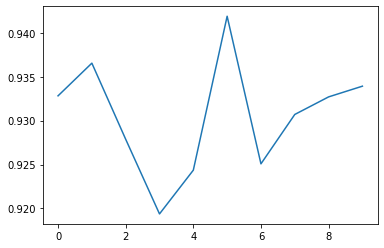

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def see_result(ex_times, path_list_path):
    
    test_acc = []
    path_list = np.load(path_list_path+'.npy')
    for path in path_list:
        df_train = pd.read_csv(path + '_train_result.csv')
        df_test  = pd.read_csv(path + '_test_result.csv' )

        #df_train[['train_accuracy','valid_accuracy']].plot()
        #plt.show()
        #print(df_test['test_accuracy'][0])
        test_acc.append(df_test['test_accuracy'][0])
        
    print(test_acc)
    plt.plot(test_acc)
    print('均值：',np.mean(test_acc))
    print('方差：',np.std(test_acc))


    
see_result(10,'./path_list_path/FedAvg_Meta/path_list_10_25_22_56')